In [1]:
%load_ext autoreload

In [2]:
%autoreload
from torch_ham.models import ConditionalUNet

import gc
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn.functional as F

In [34]:
device = torch.device('cuda')
dtype = torch.float32

data_path = os.path.expanduser('~/data/compass.jld2')
compass = torch.tensor(np.array(h5py.File(data_path)['v']), device=torch.device('cpu'), dtype=dtype)
compass = torch.permute(compass, (2, 1, 0))
nx, ny, nz = compass.shape
compass = compass-torch.min(compass)
compass = compass/torch.max(compass)

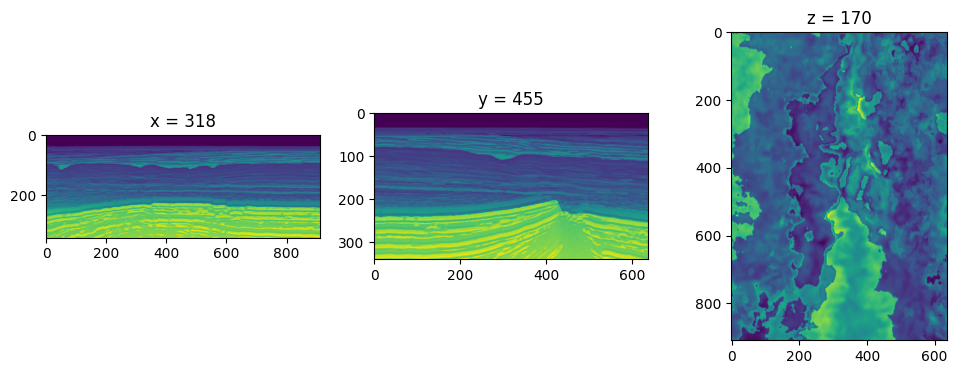

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(compass[nx//2,:,:].T)
plt.title(f'x = {nx//2}')
plt.subplot(132)
plt.title(f'y = {ny//2}')
plt.imshow(compass[:,ny//2,:].T)
plt.subplot(133)
plt.title(f'z = {nz//2}')
plt.imshow(compass[:,:,nz//2].T)

In [191]:
%autoreload

# Number of wells for kriging
n_wells = 4
depth = 4

model = ConditionalUNet(
    input_size = (nx, nz),
    condition_size = (n_wells, nz),
    kernel_size = (8, 8),
    downsample = (4, 4),
    depth = depth,
    in_channels = 1,
    channel_scale = 2,
    device=device,
    dtype=dtype
)

# Count model params
print(sum(p.numel() for p in model.parameters()))

359165


In [192]:
# ==== Optimization setup ====
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
batch_size = 1
n_examples = 10_000
n_batches = n_examples // batch_size
alpha = 0.5

In [193]:
gc.collect()

# Main training loop
for i in range(n_batches):
    
    # Select slices and wells
    idxs = torch.tensor(np.random.randint(0, ny, size=batch_size), dtype=torch.long)
    idxs = torch.tensor([ny//2], dtype=torch.long)
    slices = torch.index_select(compass, dim=1, index=idxs).transpose(0, 1).unsqueeze(1)
    well_idxs = torch.tensor(np.random.randint(0, nx, size=(batch_size, n_wells)), dtype=torch.long)
    well_idxs = torch.tensor([100, 250, 400, 550], dtype=torch.long).view(batch_size, n_wells)
    wells = torch.cat([torch.index_select(sl, dim=1, index=wi).unsqueeze(0) for sl, wi in zip(slices, well_idxs)], dim=0).view(batch_size, n_wells, nz)
    
    wells = wells.to(device).requires_grad_(True)
    slices = slices.to(device).requires_grad_(True)
    
    # Init states
    states = model.init_states(
        batch_size=batch_size,
        exclude={'c'},
        device=device,
        dtype=dtype,
        requires_grad=True
    )
    
    states['c'] = wells
    optim.zero_grad()
    
    loss = torch.zeros(batch_size, device=device, dtype=dtype)
    
    for d in range(depth):
        activations = model.activations(states)
        grads = model.grads(states, activations)
        states = model.step(states, grads, alpha, pin={'c'})
    
    print(f'i = {i+1:06d}/{n_batches:06d}, loss = {loss.item():2.8f}', end='\r',  flush=True)
    loss.backward()
    optim.step()

KeyboardInterrupt: 

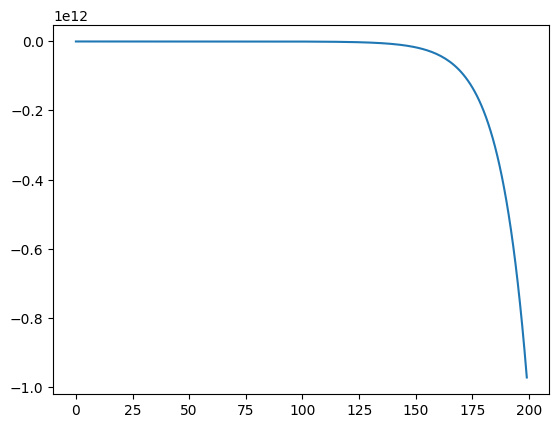

In [196]:
%autoreload

gc.collect()

# Init states
states = model.init_states(
    batch_size=batch_size,
    exclude={'c'},
    device=device,
    dtype=dtype,
    requires_grad=True
)

states['c'] = wells
optim.zero_grad()
energies = []
for d in range(200):
    activations = model.activations(states)
    energies.append(model.energy(states, activations).item())
    grads = model.grads(states, activations, create_graph=False)
    states = model.step(states, grads, alpha=0.2, pin={'c'})
    
plt.plot(energies)

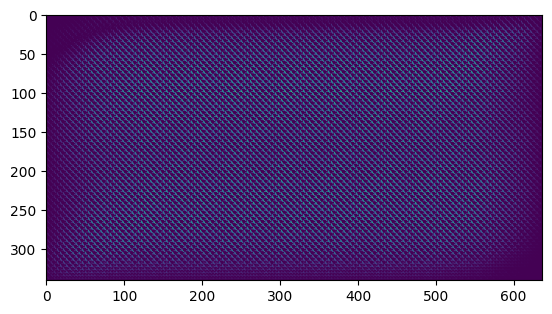

In [197]:
activations = model.activations(states)
img = activations['n0'].detach().squeeze().cpu().numpy()
plt.imshow(img.T)